<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Fixed-Parameters" data-toc-modified-id="Fixed-Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fixed Parameters</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Current-Status" data-toc-modified-id="Current-Status-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Current Status</a></span></li><li><span><a href="#Current-Proposal" data-toc-modified-id="Current-Proposal-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Current Proposal</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Rescale-PV-Capacity" data-toc-modified-id="Rescale-PV-Capacity-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Rescale PV Capacity</a></span></li><li><span><a href="#Extend-Columns" data-toc-modified-id="Extend-Columns-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Extend Columns</a></span></li><li><span><a href="#Totals" data-toc-modified-id="Totals-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Totals</a></span><ul class="toc-item"><li><span><a href="#Original-PV-Capacity" data-toc-modified-id="Original-PV-Capacity-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Original PV Capacity</a></span></li><li><span><a href="#New-PV-Capacity" data-toc-modified-id="New-PV-Capacity-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>New PV Capacity</a></span></li></ul></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Optimization</a></span></li></ul></div>

### Imports

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import product

In [161]:
DEBUG = False

### Code

In [162]:
def get_offset_value(df, timestamp, offset, column_name, default_value=None):
    try:
        # Get the index position of the reference timestamp
        current_pos = df.index.get_loc(timestamp)

        # Calculate the target position
        target_pos = current_pos + offset

        # Check if the target position is within bounds
        if 0 <= target_pos < len(df):
            target_timestamp = df.index[target_pos]
            return df.loc[target_timestamp, column_name]
        else:
            return default_value
    except (KeyError, ValueError):
        # Handle cases where timestamp isn't found in the index
        return default_value

In [163]:
def get_column_total(df, column_name, cumulative_columns, non_cumulative_columns):
    # Check if column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    # Check if column is in our predefined lists
    if column_name in cumulative_columns:
        # For cumulative columns, return the final value
        return df[column_name].iloc[-1]
    elif column_name in non_cumulative_columns:
        # For non-cumulative columns, return the sum
        return df[column_name].sum()
    else:
        # Default case for columns not in our lists - sum them
        print(f"Warning: Column '{column_name}' not found in either cumulative or non-cumulative lists. Defaulting to sum.")
        return df[column_name].sum()

In [164]:
def load_and_prepare_data(
    import_file,
    columns_map):
    
    df = pd.read_csv(import_file)

    # First, reverse the columns_map dictionary to map old names to new names
    reverse_columns_map = {v: k for k, v in columns_map.items()}

    # Now rename the columns using the reversed mapping
    df = df.rename(columns=reverse_columns_map)

    # Set Index
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%m/%d/%Y %H:%M')

    # Set the datetime column as the index
    df.set_index('time_stamp', inplace=True)

    # Ensure the index is sorted chronologically
    df.sort_index(inplace=True)
    
    return df

In [165]:
def rescale_solar_production(df_original, original_capacity, new_capacity):
    """
    Rescale solar production data from original PV capacity to new PV capacity.

    Assumptions:
    1. Solar production scales linearly with panel capacity
    2. Consumption remains the same
    3. Export is increased production minus any additional self-consumption
    4. Import is reduced by any additional self-consumption

    Parameters:
    df_original (pd.DataFrame): Original DataFrame with energy data
    original_capacity (float): Original solar capacity in kWc
    new_capacity (float): New solar capacity in kWc

    Returns:
    pd.DataFrame: New DataFrame with rescaled values
    """
    # Make a copy of the original dataframe to avoid modifying it
    df = df_original.copy()

    # Calculate scaling factor
    scaling_factor = new_capacity / original_capacity

    # Rescale produced_wh (solar production scales directly with panel capacity)
    df['produced_wh'] = df['produced_wh'] * scaling_factor

    # Calculate how much additional energy is now produced
    additional_production = df['produced_wh'] - df_original['produced_wh']

    # Calculate how much of this additional production can be self-consumed
    # This is the minimum between additional production and what would have been imported
    potential_self_consumption = df_original['imported_wh']
    additional_self_consumption = np.minimum(additional_production, potential_self_consumption)

    # Calculate new values for imported_wh and exported_wh
    # Imported energy decreases by the additional self-consumption
    df['imported_wh'] = df_original['imported_wh'] - additional_self_consumption
    df['imported_wh'] = df['imported_wh'].clip(lower=0)  # Can't have negative imports

    # Exported energy is original export plus any additional production not self-consumed
    df['exported_wh'] = df_original['exported_wh'] + (additional_production - additional_self_consumption)

    # Consumed energy stays the same (assumption in the problem statement)
    # But let's verify that energy balance still makes sense
    # Total energy available = produced + imported (from grid)
    # Total energy used = consumed + exported (to grid)
    # The difference between these should be zero

    # Return the rescaled dataframe
    return df

In [166]:
def extend_all_columns(
    original_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    max_battery_capacity_wh):

    df = original_df.copy()
    
    # Raw initial value
    initial_battery_capacity = 0.0
    
    # Determine the electricity price based on time of day
    def get_wh_price(time):

        hour = time.hour
        if hour < 7 or hour >= 23:  # before 7:00 or after 23:00
            return wh_price_low_eur
        else:
            return wh_price_high_eur
    
    # Calculate subscription fee per 15-minute interval
    df['subscription_fee_eur'] = (12 * subscription_monthly_fee_eur) / (24 * 4 * 365)

    # Calculate exportation price
    df['exportation_price_eur'] = df['exported_wh'] * wh_price_sale_eur

    # Apply the time-based pricing to each row
    df['wh_price_eur'] = df.index.map(get_wh_price)

    # Calculate importated price
    df['imported_price_eur'] = df['imported_wh'] * df['wh_price_eur']

    # Calculate consumed price
    df['consumed_price_eur'] = df['consumed_wh'] * df['wh_price_eur']

    # Calculate net exported energy
    df['net_exported_wh'] = df['exported_wh'] - df['imported_wh']

    # Create a new column initialized with NaN
    df['current_battery_capacity_wh'] = np.nan

    # Set the first value
    df.loc[df.index[0], 'current_battery_capacity_wh'] = initial_battery_capacity

    # Use a list to store values and then assign all at once
    battery_values = [initial_battery_capacity]
    
    for i in range(1, len(df)):
        prev_capacity = battery_values[i-1]
        net_exported = df['net_exported_wh'].iloc[i]
        new_capacity = max(0, min(max_battery_capacity_wh, prev_capacity + net_exported))
        battery_values.append(new_capacity)

    # Assign all values at once to avoid chained assignment warning
    df['current_battery_capacity_wh'] = battery_values

    # First initialize the column with NaN
    df['exported_to_battery_wh'] = np.nan

    # For the first row, the exported to battery is 0 since there's no previous state
    battery_export_values = [0]  # First value is 0 as there's no previous state

    # Iterate through the remaining rows to calculate the values
    for i in range(1, len(df)):
        current_capacity = df['current_battery_capacity_wh'].iloc[i]
        prev_capacity = df['current_battery_capacity_wh'].iloc[i-1] if i > 0 else initial_battery_capacity

        # Calculate the difference (current - previous) and take max with 0
        diff = current_capacity - prev_capacity
        exported_value = max(0, diff)
        battery_export_values.append(exported_value)

    # Assign all values at once to avoid chained assignment warning
    df['exported_to_battery_wh'] = battery_export_values

    # Calculate non-exportation price by multiplying the exported_to_battery_wh by the sale price
    df['non_exportation_price_eur'] = df['exported_to_battery_wh'] * wh_price_sale_eur

    # First initialize the column with NaN
    df['imported_from_battery_wh'] = np.nan

    # For the first row, the imported to battery is 0 since there's no previous state
    battery_import_values = [0]  # First value is 0 as there's no previous state

    # Iterate through the remaining rows to calculate the values
    for i in range(1, len(df)):
        current_capacity = df['current_battery_capacity_wh'].iloc[i]
        prev_capacity = df['current_battery_capacity_wh'].iloc[i-1] if i > 0 else initial_battery_capacity

        diff = current_capacity - prev_capacity
        imported_value = -1*min(0, diff)
        battery_import_values.append(imported_value)

    # Assign all values at once to avoid chained assignment warning
    df['imported_from_battery_wh'] = battery_import_values

    # Calculate non-importation price by multiplying the imported_from_battery_wh by the wh price
    df['non_importation_price_eur'] = df['exported_to_battery_wh'] * df['wh_price_eur']
    
    return df

In [217]:
def extend_all_columns_with_recharge(
    original_df,
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    max_battery_capacity_wh,
    max_battery_charge_rate_w=3000):  # Changed from kW to W (default 3000W = 3kW)

    df = original_df.copy()

    # Raw initial value
    initial_battery_capacity = 0.0

    # Determine the electricity price based on time of day
    def get_wh_price(time):
        hour = time.hour
        if hour < 7 or hour >= 23:  # before 7:00 or after 23:00
            return wh_price_low_eur
        else:
            return wh_price_high_eur

    # Calculate subscription fee per 15-minute interval
    df['subscription_fee_eur'] = (12 * subscription_monthly_fee_eur) / (24 * 4 * 365)
    # Calculate exportation price
    df['exportation_price_eur'] = df['exported_wh'] * wh_price_sale_eur
    # Apply the time-based pricing to each row
    df['wh_price_eur'] = df.index.map(get_wh_price)
    # Calculate consumed price
    df['consumed_price_eur'] = df['consumed_wh'] * df['wh_price_eur']
    # Calculate net exported energy (initial calculation)
    df['net_exported_wh'] = df['exported_wh'] - df['imported_wh']
    # Create a new column initialized with NaN
    df['current_battery_capacity_wh'] = np.nan
    # Set the first value
    df.loc[df.index[0], 'current_battery_capacity_wh'] = initial_battery_capacity
    # Use a list to store values and then assign all at once
    battery_values = [initial_battery_capacity]
    # Store modified imported_wh values
    modified_imported_wh = [df['imported_wh'].iloc[0]]
    # Store modified net_exported_wh values
    modified_net_exported_wh = [df['net_exported_wh'].iloc[0]]

    # Convert max charge rate from W to Wh per 15-minute interval
    # Since 1W = 1J/s and 1Wh = 3600J, we don't need to convert units here
    # But we need to account for the 15-minute interval (0.25 hours)
    max_charge_rate_wh = max_battery_charge_rate_w * 0.25  # W to Wh per 15 minutes

    for i in range(1, len(df)):
        prev_capacity = battery_values[i-1]
        current_time = df.index[i]
        current_hour = current_time.hour
        is_low_price_period = (current_hour < 7) or (current_hour >= 23)

        # Original values before battery charging adjustments
        original_imported = df['imported_wh'].iloc[i]
        original_net_exported = df['net_exported_wh'].iloc[i]

        # Calculate potential new capacity without considering charge rate limits
        potential_new_capacity = max(0, min(max_battery_capacity_wh, prev_capacity + original_net_exported))

        # Initialize battery charge amount
        battery_charge_from_grid = 0

        # For low price periods, consider charging from grid
        if is_low_price_period:
            # Calculate available capacity in battery
            available_capacity = max_battery_capacity_wh - prev_capacity

            # Calculate how much we could charge from grid:
            # 1. Available capacity in battery
            # 2. Maximum charge rate (now in Wh per 15 minutes)
            # 3. Only charge if we have positive net import (we're buying from grid)
            max_possible_charge = min(
                available_capacity,  # remaining capacity
                max_charge_rate_wh,  # charge rate limit (in Wh per interval)
                max(0, -original_net_exported)  # Only if we're net importing from grid
            )

            # Additional check: don't charge if we're already exporting (negative net_exported means we're importing)
            if original_net_exported < 0:  # We're importing from grid
                battery_charge_from_grid = max_possible_charge

            # Update the net exported energy (which really represents net grid interaction)
            adjusted_net_exported = original_net_exported + battery_charge_from_grid
            # Since net_exported = exported_wh - imported_wh,
            # adding battery_charge_from_grid effectively increases imported_wh

            # Calculate new capacity considering both solar and grid charging
            new_capacity = min(
                max_battery_capacity_wh,
                prev_capacity + original_net_exported + battery_charge_from_grid
            )
        else:
            # During high price periods, don't actively charge from grid
            adjusted_net_exported = original_net_exported
            new_capacity = min(
                max_battery_capacity_wh,
                prev_capacity + original_net_exported
            )

        # Ensure capacity stays within bounds
        new_capacity = max(0, new_capacity)
        battery_values.append(new_capacity)
        modified_net_exported_wh.append(adjusted_net_exported)

        # Calculate actual imported_wh by rearranging: net_exported = exported_wh - imported_wh
        # So imported_wh = exported_wh - net_exported
        original_exported = df['exported_wh'].iloc[i]
        new_imported_wh = original_exported - adjusted_net_exported
        modified_imported_wh.append(new_imported_wh)

    # Update the columns with our modified values
    df['net_exported_wh'] = modified_net_exported_wh
    df['imported_wh'] = modified_imported_wh
    df['current_battery_capacity_wh'] = battery_values

    # Calculate imported_price_eur with the updated imported_wh values
    df['imported_price_eur'] = df['imported_wh'] * df['wh_price_eur']

    # First initialize the column with NaN
    df['exported_to_battery_wh'] = np.nan
    # For the first row, the exported to battery is 0 since there's no previous state
    battery_export_values = [0]  # First value is 0 as there's no previous state

    # Iterate through the remaining rows to calculate the values
    for i in range(1, len(df)):
        current_capacity = df['current_battery_capacity_wh'].iloc[i]
        prev_capacity = df['current_battery_capacity_wh'].iloc[i-1] if i > 0 else initial_battery_capacity
        # Calculate the difference (current - previous) and take max with 0
        diff = current_capacity - prev_capacity
        exported_value = max(0, diff)
        battery_export_values.append(exported_value)

    # Assign all values at once to avoid chained assignment warning
    df['exported_to_battery_wh'] = battery_export_values
    # Calculate non-exportation price by multiplying the exported_to_battery_wh by the sale price
    df['non_exportation_price_eur'] = df['exported_to_battery_wh'] * wh_price_sale_eur

    # First initialize the column with NaN
    df['imported_from_battery_wh'] = np.nan
    # For the first row, the imported to battery is 0 since there's no previous state
    battery_import_values = [0]  # First value is 0 as there's no previous state

    # Iterate through the remaining rows to calculate the values
    for i in range(1, len(df)):
        current_capacity = df['current_battery_capacity_wh'].iloc[i]
        prev_capacity = df['current_battery_capacity_wh'].iloc[i-1] if i > 0 else initial_battery_capacity
        diff = current_capacity - prev_capacity
        imported_value = -1*min(0, diff)
        battery_import_values.append(imported_value)

    # Assign all values at once to avoid chained assignment warning
    df['imported_from_battery_wh'] = battery_import_values
    # Calculate non-importation price by multiplying the imported_from_battery_wh by the wh price
    df['non_importation_price_eur'] = df['imported_from_battery_wh'] * df['wh_price_eur']

    return df


In [167]:
def get_fixed_fees(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    if DEBUG:
        print('entering >> get_fixed_fees')

    
    subscription_fee_eur = get_column_total(
        df,
        'subscription_fee_eur',
        cumulative_columns,
        non_cumulative_columns)
    
    if DEBUG:
        print(f'  subscription_fee_eur: {subscription_fee_eur}')
    
    
    result = subscription_fee_eur
    
    if DEBUG:
        print(f'  > get_fixed_fees: {result}')
    
    if DEBUG:
        print('')
        
    return result

In [168]:
def get_total_cost(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    if DEBUG:
        print('entering >> get_total_cost')

    
    fixed = get_fixed_fees(
        df,
        cumulative_columns,
        non_cumulative_columns)
    
    consumed_price_eur = get_column_total(
        df,
        'consumed_price_eur',
        cumulative_columns, 
        non_cumulative_columns)

    if DEBUG:
        print(f'  consumed_price_eur: {consumed_price_eur}')
    
    
    result = fixed + consumed_price_eur
    
    if DEBUG:
        print(f'  > get_total_cost: {result}')
    
    
    if DEBUG:
        print('')
        
    return result

In [169]:
def get_total_cost_with_pv(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    if DEBUG:
        print('entering >> get_total_cost_with_pv')
    
    fixed = get_fixed_fees(
        df,
        cumulative_columns,
        non_cumulative_columns)
    
    imported_price_eur = get_column_total(
        df,
        'imported_price_eur',
        cumulative_columns, 
        non_cumulative_columns)

    if DEBUG:
        print(f'  imported_price_eur: {imported_price_eur}')

    
    exportation_price_eur = get_column_total(
        df,
        'exportation_price_eur',
        cumulative_columns,
        non_cumulative_columns)

    if DEBUG:
        print(f'  exportation_price_eur: {exportation_price_eur}')
    
    
    result = fixed + imported_price_eur - exportation_price_eur
    
    if DEBUG:
        print(f'  > get_total_cost_with_pv: {result}')
    
    if DEBUG:
        print('')
        
    return result

In [170]:
def get_total_cost_with_pv_and_battery(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    if DEBUG:
        print('entering >> get_total_cost_with_pv_and_battery')
    
    p1 = get_total_cost_with_pv(
        df,
        cumulative_columns,
        non_cumulative_columns)

    
    
    non_importation_price_eur = get_column_total(
        df,
        'non_importation_price_eur',
        cumulative_columns, 
        non_cumulative_columns)
    
    if DEBUG:
        print(f'  non_importation_price_eur: {non_importation_price_eur}')

    
    
    non_exportation_price_eur = get_column_total(
        df,
        'non_exportation_price_eur',
        cumulative_columns,
        non_cumulative_columns)

    if DEBUG:
        print(f'  non_exportation_price_eur: {non_exportation_price_eur}')

    
    result = p1 - non_importation_price_eur + non_exportation_price_eur
    
    if DEBUG:
        print(f'  > get_total_cost_with_pv_and_battery: {result}')
    
    if DEBUG:
        print('')
        
    return result

In [171]:
def get_total_saving_with_pv(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    p1 = get_total_cost(df, cumulative_columns, non_cumulative_columns)
    p2 = get_total_cost_with_pv(df, cumulative_columns, non_cumulative_columns)    
    
    return p1 - p2

In [172]:
def get_total_saving_with_battery(
    df,
    cumulative_columns,
    non_cumulative_columns):
    
    p1 = get_total_cost_with_pv(df, cumulative_columns, non_cumulative_columns)
    p2 = get_total_cost_with_pv_and_battery(df, cumulative_columns, non_cumulative_columns)    
    
    return p1 - p2

In [199]:
def get_kpis_for(df, pv_capacity, battery_capacity, print_out=True):
    
    total_cost = get_total_cost(
        df,
        cumulative_columns,
        non_cumulative_columns)

    total_cost_with_pv = get_total_cost_with_pv(
        df,
        cumulative_columns,
        non_cumulative_columns)

    total_cost_with_pv_and_battery = get_total_cost_with_pv_and_battery(
        df,
        cumulative_columns,
        non_cumulative_columns)

    total_saving_with_pv = get_total_saving_with_pv(
        df,
        cumulative_columns,
        non_cumulative_columns)

    total_saving_with_battery = get_total_saving_with_battery(
        df,
        cumulative_columns,
        non_cumulative_columns)
    
    if print_out:
        print(f'Recap for PV={int(pv_capacity)}kWc and BATTERY={int(battery_capacity/1000.0)}kWh')
        print(f'')
        print(f'total_cost: {int(total_cost)} €')
        print(f'total_cost_with_pv: {int(total_cost_with_pv)} €')
        print(f'total_cost_with_pv_and_battery: {int(total_cost_with_pv_and_battery)} €')
        print(f'total_saving_with_pv: {int(total_saving_with_pv)} €')    
        print(f'total_saving_with_battery: {int(total_saving_with_battery)} €')
        print(f'')
        print(f'')
    
    return total_cost, total_cost_with_pv, total_cost_with_pv_and_battery, total_saving_with_pv, total_saving_with_battery

In [225]:
def plot_battery_charge(df, start_date=None, end_date=None):
    """
    Plot battery charge level with different colors for charging from solar vs grid.

    Parameters:
    df: DataFrame containing the battery data
    start_date: optional start date for the plot (datetime)
    end_date: optional end date for the plot (datetime)
    """
    # Make a copy of the dataframe to work with
    plot_df = df.copy()

    # Convert start_date and end_date to datetime if they're strings
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(end_date, str):
        end_date = pd.to_datetime(end_date)

    # Filter by date range if provided
    if start_date is not None:
        plot_df = plot_df[plot_df.index >= start_date]
    if end_date is not None:
        plot_df = plot_df[plot_df.index <= end_date]

    # Create a list to store charge source information
    charge_sources = []

    # Determine charge source for each period
    for i in range(1, len(plot_df)):
        prev_capacity = plot_df['current_battery_capacity_wh'].iloc[i-1]
        current_capacity = plot_df['current_battery_capacity_wh'].iloc[i]
        time = plot_df.index[i]
        hour = time.hour

        # Check if battery capacity increased
        if current_capacity > prev_capacity:
            # Check if it's during low price period (grid charging likely)
            is_low_price_period = (hour < 7) or (hour >= 23)

            # Also check if there was net export (solar surplus)
            net_export = plot_df['net_exported_wh'].iloc[i]
            solar_surplus = net_export > 0

            if is_low_price_period:
                # During night, charging likely from grid
                charge_sources.append('grid')
            elif solar_surplus:
                # If there's solar surplus and it's daytime, assume charging from solar
                charge_sources.append('solar')
            else:
                # Default to grid if we can't determine
                charge_sources.append('grid')
        else:
            # No charging happening (or discharging)
            charge_sources.append('none')

    # Add the first entry as 'none' to match the length of the dataframe
    charge_sources.insert(0, 'none')

    # Add charge source information to the dataframe
    plot_df['charge_source'] = charge_sources

    # Create the plot
    plt.figure(figsize=(14, 7))

    # Plot the battery level
    plt.plot(plot_df.index, plot_df['current_battery_capacity_wh']/1000,  # Convert to kWh for plotting
             color='black', linewidth=2, label='Battery Level (kWh)')

    # Fill between the battery levels with appropriate colors based on charge source
    # We'll plot each interval separately with the correct color
    for i in range(1, len(plot_df)):
        # Skip if no change in battery level
        if plot_df['current_battery_capacity_wh'].iloc[i] == plot_df['current_battery_capacity_wh'].iloc[i-1]:
            continue

        x = [plot_df.index[i-1], plot_df.index[i]]
        y1 = [plot_df['current_battery_capacity_wh'].iloc[i-1]/1000, plot_df['current_battery_capacity_wh'].iloc[i]/1000]

        # Only fill if there was charging (increase in battery level)
        if y1[1] > y1[0]:
            charge_type = plot_df['charge_source'].iloc[i]

            if charge_type == 'solar':
                plt.fill_between(x, y1[0], y1[1], color='#FFA500', alpha=0.5, label='Solar Charging' if i == 1 else "")
            elif charge_type == 'grid':
                plt.fill_between(x, y1[0], y1[1], color='#1E90FF', alpha=0.5, label='Grid Charging' if i == 1 else "")

    # Add labels and formatting
    plt.title('Battery Charge Level Over Time')
    plt.xlabel('Date/Time')
    plt.ylabel('Battery Capacity (kWh)')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)

    # Create legend handles manually since we can't rely on automatic legend for fill_between
    handles = [
        plt.Line2D([0], [0], color='#FFA500', lw=4, label='Solar Charging'),
        plt.Line2D([0], [0], color='#1E90FF', lw=4, label='Grid Charging'),
        plt.Line2D([0], [0], color='black', lw=2, label='Battery Level')
    ]
    plt.legend(handles=handles)

    # Format x-axis for better readability of dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

### Configuration

In [174]:
import_file = 'data/enphase_report.csv'

In [175]:
columns_map = {
    "produced_wh": "Énergie produite (Wh)",
    "consumed_wh": "Énergie consommée (Wh)",
    "exported_wh": "Exportée vers le réseau (Wh)",
    "imported_wh": "Importée depuis le réseau (Wh)",
    "time_stamp": "Date/Heure",
}

In [176]:
cumulative_columns = [
    'current_battery_capacity_wh'
]

In [177]:
non_cumulative_columns = [
    'subscription_fee_eur',
    'exportation_price_eur',
    'wh_price_eur',
    'imported_price_eur',
    'consumed_price_eur',
    'non_exportation_price_eur',
    'non_importation_price_eur',
    'produced_wh',
    'consumed_wh',
    'exported_wh',
    'imported_wh',
    'net_exported_wh',
    'exported_to_battery_wh', 
    'imported_from_battery_wh'
]

### Fixed Parameters

In [178]:
# Today's costs of energy
subscription_monthly_fee_eur = 47.0200
wh_price_high_eur = 0.0002081
wh_price_low_eur = 0.0001635
wh_price_sale_eur = 0.0001000

In [179]:
# Today's system characteristics
pv_capacity = 6.0
battery_capacity = 0.0

### Loading Data

In [180]:
raw_df = load_and_prepare_data(
    import_file,
    columns_map)

In [181]:
original_df = extend_all_columns(
    raw_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    battery_capacity)

### Current Status

In [182]:
original_kpis = get_kpis_for(
    original_df,
    pv_capacity, 
    battery_capacity,
    print_out=True)

Recap for PV=6kWc and BATTERY=0kWh

total_cost: 3603 €
total_cost_with_pv: 2536 €
total_cost_with_pv_and_battery: 2536 €
total_saving_with_pv: 1067 €
total_saving_with_battery: 0 €




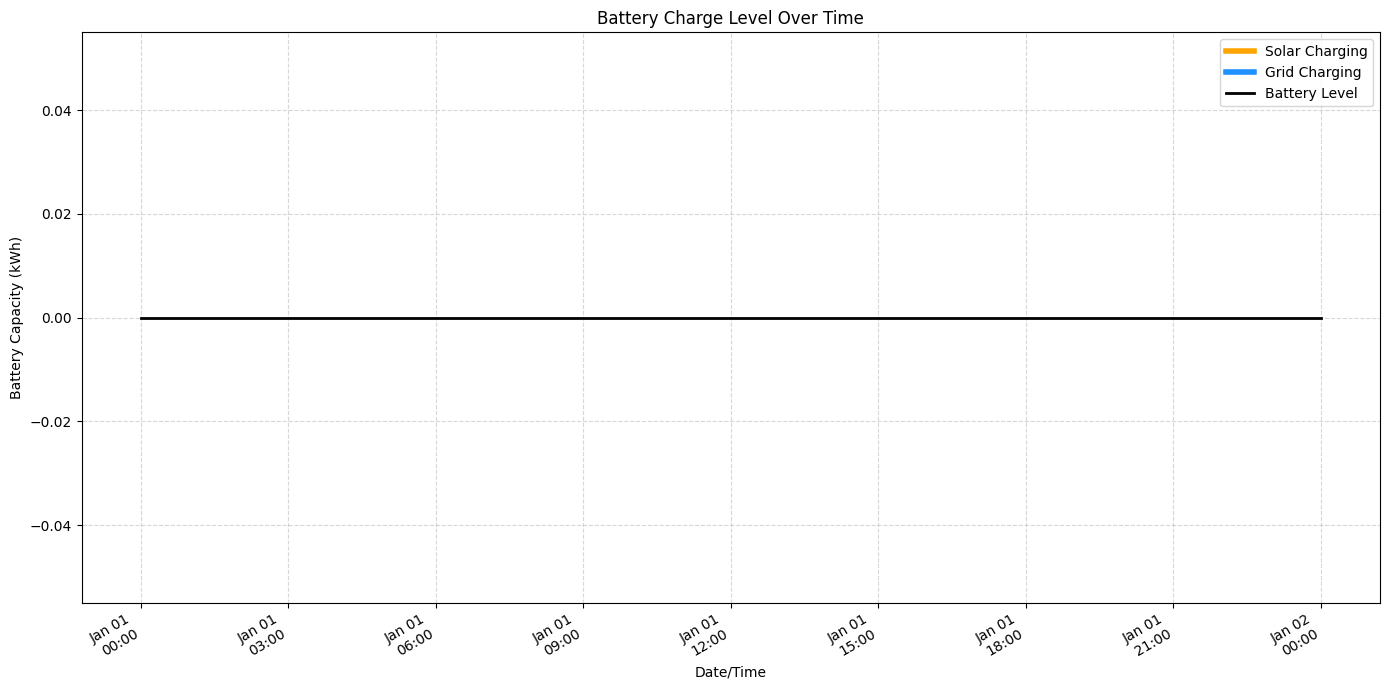

In [228]:
plot_battery_charge(original_df, start_date='2025-01-01', end_date='2025-01-02')

### Current Proposal

In [223]:
solar_cap = 9.0      # kWc
battery_cap = 10.0   # kWh

In [232]:
current_battery_cap = 1000.0 * battery_cap

# Rescale solar production
scaled_raw_df = rescale_solar_production(
    raw_df,
    pv_capacity,
    solar_cap)

# Compute all columns
scaled_df = extend_all_columns(
    scaled_raw_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    current_battery_cap)

cost, cost_with_pv, cost_with_pv_and_battery, saving_with_pv, saving_with_battery = get_kpis_for(
    scaled_df,
    solar_cap, 
    current_battery_cap,
    print_out=True)

Recap for PV=9kWc and BATTERY=10kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1841 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 283 €




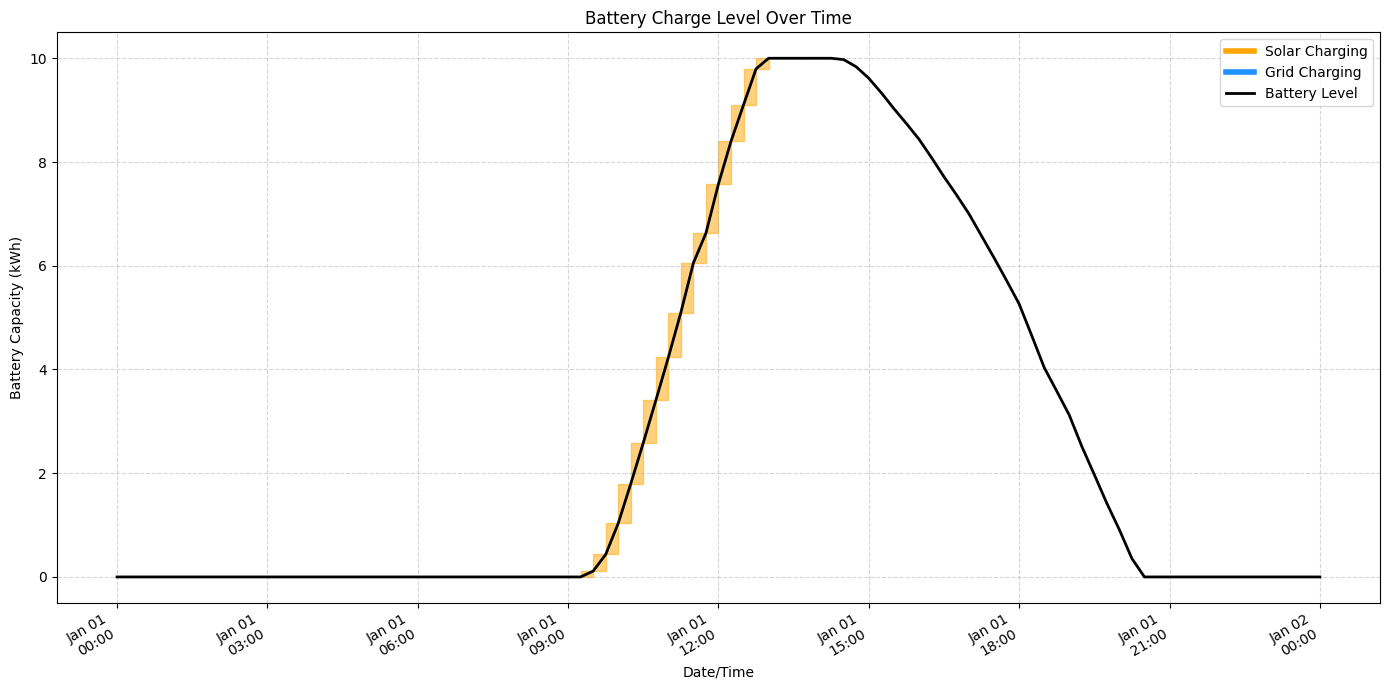

In [233]:
plot_battery_charge(scaled_df, start_date='2025-01-01', end_date='2025-01-03')

In [234]:
max_battery_charge_rate_w = current_battery_cap / 5.0

# Compute all columns
scaled_df = extend_all_columns_with_recharge(
    scaled_raw_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    current_battery_cap,
    max_battery_charge_rate_w)

cost, cost_with_pv, cost_with_pv_and_battery, saving_with_pv, saving_with_battery = get_kpis_for(
    scaled_df,
    solar_cap, 
    current_battery_cap,
    print_out=True)

Recap for PV=9kWc and BATTERY=10kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1876 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 248 €




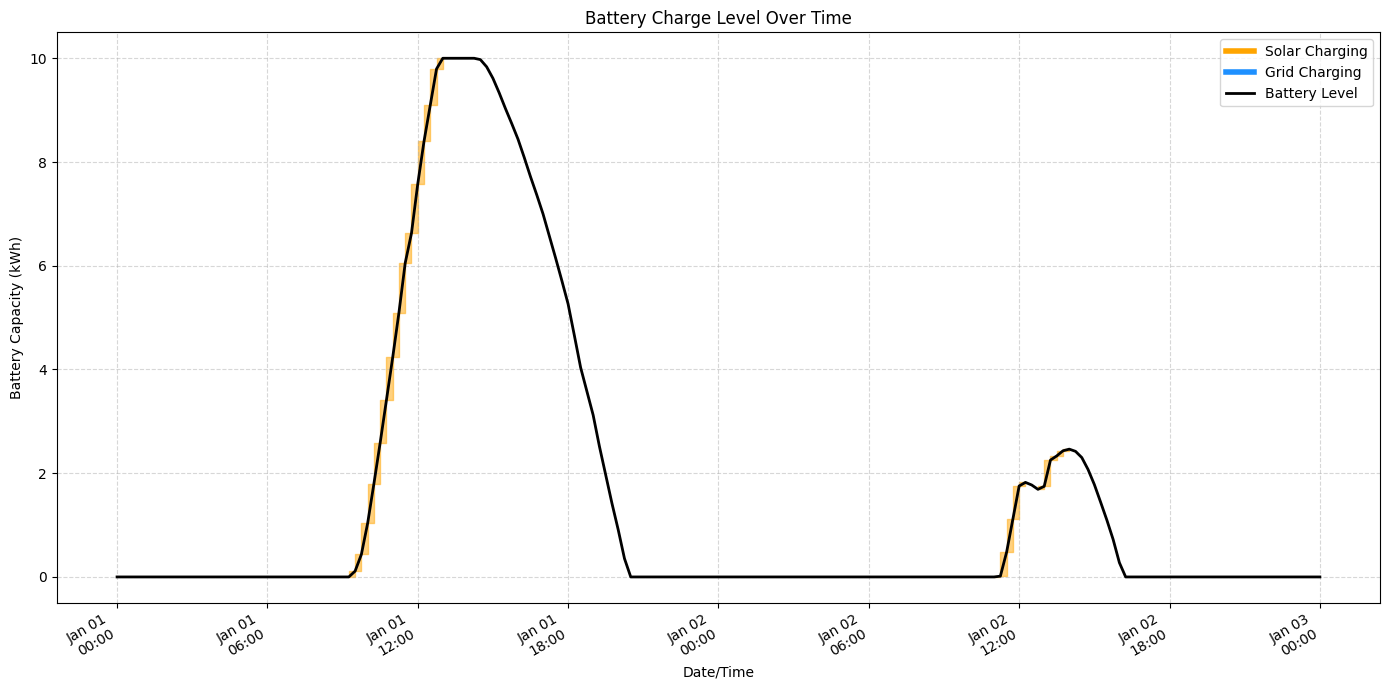

In [238]:
plot_battery_charge(scaled_df, start_date='2025-01-01', end_date='2025-01-03')

### Optimization

In [219]:
solar_cap = 9.0
battery_caps = [5.0, 10.0, 15.0, 20.0]

In [220]:
for battery_cap in battery_caps:
    
    current_battery_cap = 1000.0 * battery_cap
    
    # Rescale solar production
    scaled_raw_df = rescale_solar_production(
        raw_df,
        pv_capacity,
        solar_cap)

    # Compute all columns
    scaled_df = extend_all_columns(
        scaled_raw_df, 
        subscription_monthly_fee_eur,
        wh_price_high_eur,
        wh_price_low_eur,
        wh_price_sale_eur,
        current_battery_cap)

    cost, cost_with_pv, cost_with_pv_and_battery, saving_with_pv, saving_with_battery = get_kpis_for(
        scaled_df,
        solar_cap, 
        current_battery_cap,
        print_out=True)

Recap for PV=9kWc and BATTERY=5kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1956 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 168 €


Recap for PV=9kWc and BATTERY=10kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1841 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 283 €


Recap for PV=9kWc and BATTERY=15kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1765 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 359 €


Recap for PV=9kWc and BATTERY=20kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1721 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 404 €




In [221]:
for battery_cap in battery_caps:
    
    current_battery_cap = 1000.0 * battery_cap
    max_battery_charge_rate_w = current_battery_cap / 5.0
    
    # Rescale solar production
    scaled_raw_df = rescale_solar_production(
        raw_df,
        pv_capacity,
        solar_cap)

    # Compute all columns
    scaled_df = extend_all_columns_with_recharge(
        scaled_raw_df, 
        subscription_monthly_fee_eur,
        wh_price_high_eur,
        wh_price_low_eur,
        wh_price_sale_eur,
        current_battery_cap,
        max_battery_charge_rate_w)

    cost, cost_with_pv, cost_with_pv_and_battery, saving_with_pv, saving_with_battery = get_kpis_for(
        scaled_df,
        solar_cap, 
        current_battery_cap,
        print_out=True)

Recap for PV=9kWc and BATTERY=5kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1966 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 158 €


Recap for PV=9kWc and BATTERY=10kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1876 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 248 €


Recap for PV=9kWc and BATTERY=15kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1830 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 294 €


Recap for PV=9kWc and BATTERY=20kWh

total_cost: 3603 €
total_cost_with_pv: 2125 €
total_cost_with_pv_and_battery: 1807 €
total_saving_with_pv: 1478 €
total_saving_with_battery: 317 €




### Optimization

In [183]:
# Define ranges to test
solar_capacities = np.arange(7, 13, 1)  # From 7 to 12 kWc in 1 kWc steps
battery_capacities = np.arange(5000, 16000, 1000)  # From 5 to 15 kWh in 1 kWh steps

In [184]:
optimize_for = 'cost_with_pv_and_battery'

In [185]:
results = []

for solar_cap, battery_cap in product(solar_capacities, battery_capacities):

    # Rescale solar production
    scaled_raw_df = rescale_solar_production(
        raw_df,
        pv_capacity,
        solar_cap)

    # Compute all columns
    scaled_df = extend_all_columns(
        scaled_raw_df, 
        subscription_monthly_fee_eur,
        wh_price_high_eur,
        wh_price_low_eur,
        wh_price_sale_eur,
        battery_cap)
    
    cost, cost_with_pv, cost_with_pv_and_battery, saving_with_pv, saving_with_battery = get_kpis_for(
        scaled_df,
        solar_cap, 
        battery_cap,
        print_out=False)
    
    results.append({
        'solar_capacity': solar_cap,
        'battery_capacity': battery_cap,
        'cost': cost, 
        'cost_with_pv': cost_with_pv, 
        'cost_with_pv_and_battery': cost_with_pv_and_battery,
        'saving_with_pv': saving_with_pv, 
        'saving_with_battery': saving_with_battery,
        'self_consumption_rate': 1 - scaled_df['exported_wh'].sum()/(scaled_df['produced_wh'].sum() + 1e-6)
    })
    
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

In [190]:
# Find the configuration with minimum total cost
optimal_config = results_df.loc[results_df[optimize_for].idxmin()]

In [191]:
def plot_optimization_results(results_df, optimal_config, optimize_for):
    """Create visualizations of the optimization results."""
    # Pivot the data for plotting
    pivot_df = results_df.pivot(index='battery_capacity',
                               columns='solar_capacity',
                               values=optimize_for)

    # Create a heatmap
    plt.figure(figsize=(12, 8))
    plt.title('Total Annual Energy Cost by System Configuration')
    plt.xlabel('Solar Capacity (kWc)')
    plt.ylabel('Battery Capacity (kWh)')
    plt.pcolor(pivot_df, cmap='viridis')
    plt.colorbar(label='Total Cost (EUR)')

    # Add labels and format
    plt.xticks(np.arange(0.5, len(pivot_df.columns)+0.5), pivot_df.columns)
    plt.yticks(np.arange(0.5, len(pivot_df.index)+0.5), pivot_df.index)
    plt.gca().invert_yaxis()

    # Mark the optimal point
    optimal_solar = optimal_config['solar_capacity']
    optimal_battery = optimal_config['battery_capacity']
    plt.scatter(
        x=np.where(pivot_df.columns == optimal_solar)[0][0] + 0.5,
        y=np.where(pivot_df.index == optimal_battery)[0][0] + 0.5,
        c='red', s=100, marker='X', linewidths=3, label='Optimal'
    )
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = results_df['solar_capacity']
    y = results_df['battery_capacity']
    z = results_df[optimize_for]

    ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
    ax.set_xlabel('Solar Capacity (kWc)')
    ax.set_ylabel('Battery Capacity (kWh)')
    ax.set_zlabel('Total Cost with PV and Battery (EUR)')
    ax.set_title('System Cost Optimization')

    plt.tight_layout()
    plt.show()

    # Plot self-consumption rate
    plt.figure(figsize=(10, 6))
    
    for solar_cap in sorted(results_df['solar_capacity'].unique()):
        
        subset = results_df[results_df['solar_capacity'] == solar_cap]
        
        plt.plot(
            subset['battery_capacity'], 
            subset['self_consumption_rate'],
            marker='o',
            label=f'{solar_cap}kWc')

    plt.xlabel('Battery Capacity (kWh)')
    plt.ylabel('Self-Consumption Rate')
    plt.title('Self-Consumption Rate by System Configuration')
    plt.legend(title='Solar Capacity')
    plt.grid(True)
    plt.show()

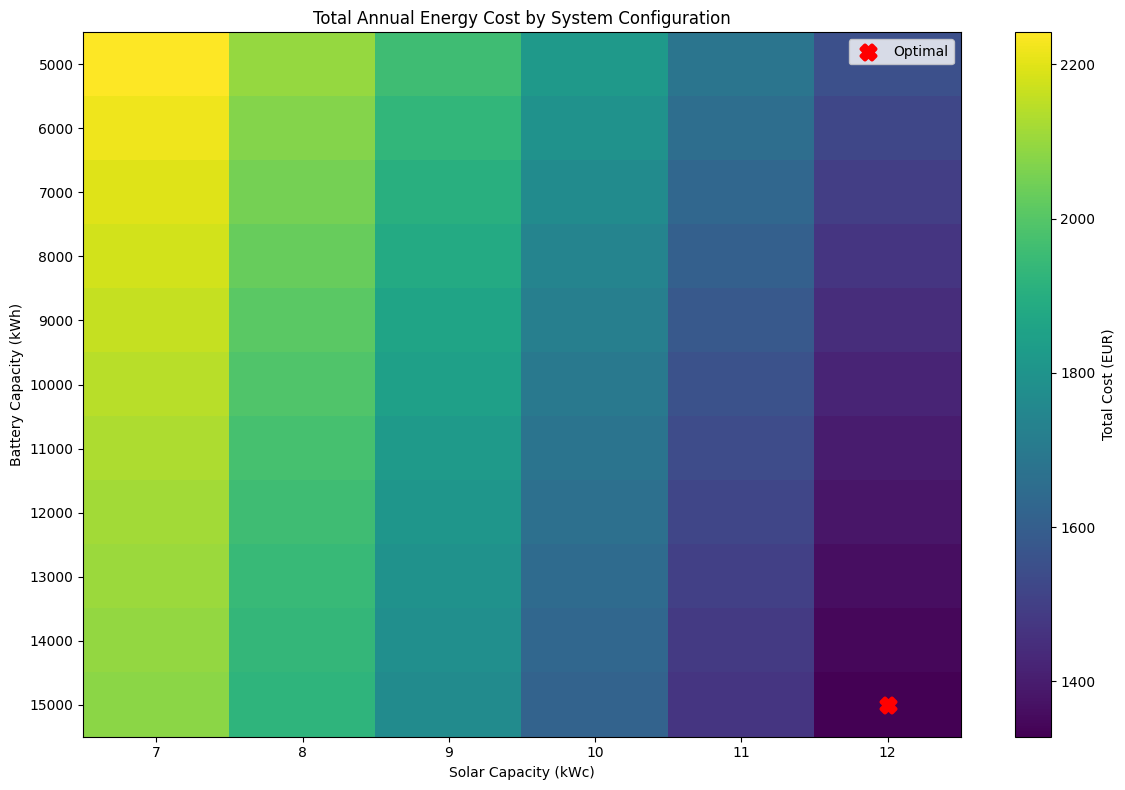

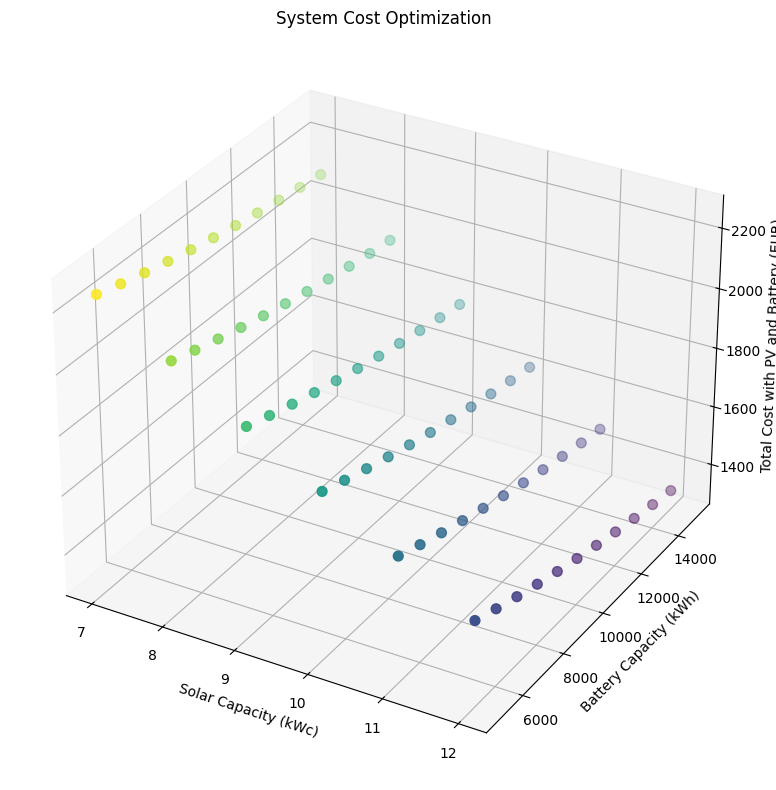

KeyError: 'battery_capacity_kWh'

<Figure size 1000x600 with 0 Axes>

In [193]:
# Generate visualizations
plot_optimization_results(results_df, optimal_config, optimize_for)

### Rescale PV Capacity to 9

In [121]:
scaled_df = rescale_solar_production(
    original_df,
    original_capacity,
    new_capacity)

In [122]:
# Let's compare some statistics between original and scaled data
def compare_energy_stats(df1, df2, name1="Original", name2="Scaled"):
    stats = {
        'Total Produced (kWh)': [df1['produced_wh'].sum()/1000, df2['produced_wh'].sum()/1000],
        'Total Consumed (kWh)': [df1['consumed_wh'].sum()/1000, df2['consumed_wh'].sum()/1000],
        'Total Exported (kWh)': [df1['exported_wh'].sum()/1000, df2['exported_wh'].sum()/1000],
        'Total Imported (kWh)': [df1['imported_wh'].sum()/1000, df2['imported_wh'].sum()/1000],
        'Self-consumption rate': [
            1 - df1['exported_wh'].sum()/(df1['produced_wh'].sum() + 1e-6),
            1 - df2['exported_wh'].sum()/(df2['produced_wh'].sum() + 1e-6)
        ]
    }
    comparison_df = pd.DataFrame(stats, index=[name1, name2])
    return comparison_df

compare_energy_stats(original_df, scaled_df)

,Total Produced (kWh),Total Consumed (kWh),Total Exported (kWh),Total Imported (kWh),Self-consumption rate
Original,7115.926,15613.963,3822.6270,12320.6730,0.462807
Scaled,10673.889,15613.963,6863.5775,11803.6605,0.356975


### Extend Columns

In [123]:
extend_all_columns(
    original_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    max_battery_capacity_wh)

In [124]:
extend_all_columns(
    scaled_df, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    max_battery_capacity_wh)

In [125]:
original_df.head(5)

,produced_wh,consumed_wh,exported_wh,imported_wh,subscription_fee_eur,exportation_price_eur,wh_price_eur,imported_price_eur,consumed_price_eur,net_exported_wh,current_battery_capacity_wh,exported_to_battery_wh,non_exportation_price_eur,imported_from_battery_wh,non_importation_price_eur
time_stamp,,,,,,,,,,,,,,,
2024-09-01 00:00:00,0,157,0,157,0.016103,0.0,0.000163,0.025669,0.025669,-157,0.0,0.0,0.0,0.0,0.0
2024-09-01 00:15:00,0,142,0,142,0.016103,0.0,0.000163,0.023217,0.023217,-142,0.0,0.0,0.0,0.0,0.0
2024-09-01 00:30:00,0,144,0,144,0.016103,0.0,0.000163,0.023544,0.023544,-144,0.0,0.0,0.0,0.0,0.0
2024-09-01 00:45:00,0,160,0,160,0.016103,0.0,0.000163,0.026160,0.026160,-160,0.0,0.0,0.0,0.0,0.0
2024-09-01 01:00:00,0,260,0,260,0.016103,0.0,0.000163,0.042510,0.042510,-260,0.0,0.0,0.0,0.0,0.0


### Totals

#### Original PV Capacity

In [126]:
_,_,_,_,_ = get_kpis_for(
    original_df,
    original_capacity)

entering >> get_total_cost
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  consumed_price_eur: 3039.5487399
  > get_total_cost: 3603.7887399

entering >> get_total_cost_with_pv
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  imported_price_eur: 2354.5915148999998
  exportation_price_eur: 382.2627
  > get_total_cost_with_pv: 2536.5688149

entering >> get_total_cost_with_pv_and_battery
entering >> get_total_cost_with_pv
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  imported_price_eur: 2354.5915148999998
  exportation_price_eur: 382.2627
  > get_total_cost_with_pv: 2536.5688149

  non_importation_price_eur: 448.09819229999994
  non_exportation_price_eur: 215.3283
  > get_total_cost_with_pv_and_battery: 2303.7989226

entering >> get_total_cost
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000

#### New PV Capacity

In [127]:
_,_,_,_,_ = get_kpis_for(
    scaled_df,
    new_capacity)

entering >> get_total_cost
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  consumed_price_eur: 3039.5487399
  > get_total_cost: 3603.7887399

entering >> get_total_cost_with_pv
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  imported_price_eur: 2247.1889796499995
  exportation_price_eur: 686.35775
  > get_total_cost_with_pv: 2125.0712296499996

entering >> get_total_cost_with_pv_and_battery
entering >> get_total_cost_with_pv
entering >> get_fixed_fees
  subscription_fee_eur: 564.2400000000002
  > get_fixed_fees: 564.2400000000002

  imported_price_eur: 2247.1889796499995
  exportation_price_eur: 686.35775
  > get_total_cost_with_pv: 2125.0712296499996

  non_importation_price_eur: 545.1453893999999
  non_exportation_price_eur: 261.9634
  > get_total_cost_with_pv_and_battery: 1841.8892402499996

entering >> get_total_cost
entering >> get_fixed_fees
  subscription_f

### Optimization

In [40]:
def optimize_system(
    import_file, 
    subscription_monthly_fee_eur,
    wh_price_high_eur,
    wh_price_low_eur,
    wh_price_sale_eur,
    initial_battery_capacity,
    original_pv_capacity,
    columns_map,
    cumulative_columns,
    non_cumulative_columns,
    battery_capacities,
    pv_capacities):

    results = []

    original_raw_df = load_and_prepare_data(
        import_file,
        columns_map)
    
    original_df = original_raw_df.copy()
    
    # No batteries today
    extend_all_columns(
        original_df, 
        subscription_monthly_fee_eur,
        wh_price_high_eur,
        wh_price_low_eur,
        wh_price_sale_eur,
        0.0, 
        0.0)
    
    for solar_cap, battery_cap in product(solar_capacities, battery_capacities):
        
        # Rescale solar production
        scaled_df = rescale_solar_production(
            original_raw_df,
            original_capacity,
            solar_cap)

        
        
        
        
        
        
        
        
        
        # Reset to original columns before processing
        rescaled_df = rescaled_df[original_columns]

        # Calculate all energy metrics with current battery capacity
        processed_df = calculate_energy_costs(
            rescaled_df,
            subscription_monthly_fee_eur=subscription_monthly_fee_eur,
            wh_price_high_eur=wh_price_high_eur,
            wh_price_low_eur=wh_price_low_eur,
            wh_price_sale_eur=wh_price_sale_eur,
            battery_capacity_wh=battery_cap * 1000,  # Convert kWh to Wh
            initial_battery_capacity=initial_battery_capacity
        )

        # Calculate KPIs
        kpis = calculate_kpis(processed_df)

        results.append({
            'solar_capacity_kWc': solar_cap,
            'battery_capacity_kWh': battery_cap,
            'total_cost': kpis['total_energy_cost_with_pv_and_battery'],
            'total_energy_cost': kpis['total_energy_cost'],
            'total_energy_cost_with_pv': kpis['total_energy_cost_with_pv'],
            'self_consumption_rate': 1 - processed_df['exported_wh'].sum()/(processed_df['produced_wh'].sum() + 1e-6)
        })

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Find the configuration with minimum total cost
    optimal_config = results_df.loc[results_df['total_cost'].idxmin()]

    return results_df, optimal_config

In [41]:
def plot_optimization_results(results_df, optimal_config):
    """Create visualizations of the optimization results."""
    # Pivot the data for plotting
    pivot_df = results_df.pivot(index='battery_capacity_kWh',
                               columns='solar_capacity_kWc',
                               values='total_cost')

    # Create a heatmap
    plt.figure(figsize=(12, 8))
    plt.title('Total Annual Energy Cost by System Configuration')
    plt.xlabel('Solar Capacity (kWc)')
    plt.ylabel('Battery Capacity (kWh)')
    plt.pcolor(pivot_df, cmap='viridis')
    plt.colorbar(label='Total Cost (EUR)')

    # Add labels and format
    plt.xticks(np.arange(0.5, len(pivot_df.columns)+0.5), pivot_df.columns)
    plt.yticks(np.arange(0.5, len(pivot_df.index)+0.5), pivot_df.index)
    plt.gca().invert_yaxis()

    # Mark the optimal point
    optimal_solar = optimal_config['solar_capacity_kWc']
    optimal_battery = optimal_config['battery_capacity_kWh']
    plt.scatter(
        x=np.where(pivot_df.columns == optimal_solar)[0][0] + 0.5,
        y=np.where(pivot_df.index == optimal_battery)[0][0] + 0.5,
        c='red', s=100, marker='X', linewidths=3, label='Optimal'
    )
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = results_df['solar_capacity_kWc']
    y = results_df['battery_capacity_kWh']
    z = results_df['total_cost']

    ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
    ax.set_xlabel('Solar Capacity (kWc)')
    ax.set_ylabel('Battery Capacity (kWh)')
    ax.set_zlabel('Total Cost (EUR)')
    ax.set_title('System Cost Optimization')

    plt.tight_layout()
    plt.show()

    # Plot self-consumption rate
    plt.figure(figsize=(10, 6))
    for solar_cap in sorted(results_df['solar_capacity_kWc'].unique()):
        subset = results_df[results_df['solar_capacity_kWc'] == solar_cap]
        plt.plot(subset['battery_capacity_kWh'], subset['self_consumption_rate'],
                marker='o', label=f'{solar_cap}kWc')

    plt.xlabel('Battery Capacity (kWh)')
    plt.ylabel('Self-Consumption Rate')
    plt.title('Self-Consumption Rate by System Configuration')
    plt.legend(title='Solar Capacity')
    plt.grid(True)
    plt.show()

In [42]:
# Define ranges to test
solar_capacities = np.arange(7, 13, 1)  # From 7 to 12 kWc in 1 kWc steps
battery_capacities = np.arange(5, 16, 1)  # From 5 to 15 kWh in 1 kWh steps

# Run optimization with your original data
# Assuming your original dataframe is called 'original_df'
results_df, optimal_config = optimize_system(original_df, solar_capacities, battery_capacities)

# Display results
print("\nOptimal Configuration Found:")
print(f"Solar Capacity: {optimal_config['solar_capacity_kWc']} kWc")
print(f"Battery Capacity: {optimal_config['battery_capacity_kWh']} kWh")
print(f"Minimum Total Cost: {optimal_config['total_cost']:.2f} EUR/year")
print(f"Baseline Cost (no PV): {optimal_config['total_energy_cost']:.2f} EUR/year")
print(f"Cost with PV only: {optimal_config['total_energy_cost_with_pv']:.2f} EUR/year")

# Generate visualizations
plot_optimization_results(results_df, optimal_config)

KeyboardInterrupt: 